# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories, using pytorch.

It is recommended to use a GPU to run this notebook. This will drastically speed up computations.

In [1]:
%pip install pandas matplotlib seaborn scipy numpy
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import multiprocessing

%pip install --upgrade --no-deps git+https://github.com/pascalbianchi/5244EP.git
from ep5244.lab5 import plot_proba_from_model, plot_confusion_matrix, FixedKernels_processing

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/pascalbianchi/5244EP.git to c:\users\24991\appdata\local\temp\pip-req-build-08espdnk
  Resolved https://github.com/pascalbianchi/5244EP.git to commit 011db03d10950309ba78c41a2aa0f91940d11601
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/pascalbianchi/5244EP.git 'C:\Users\24991\AppData\Local\Temp\pip-req-build-08espdnk'


In [2]:
%pip show torch

Name: torch
Version: 2.5.1+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: C:\Users\24991\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: ep5244, torchaudio, torchvision
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [4]:
# If you have a GPU installed and configured correctly, this code will allow the use of gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    batch_size = 128
    pin_memory = True
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS backend for GPU acceleration.")
    batch_size = 128  # Adjust batch size for performance tuning
else:
    print("No GPU found, running on CPU.")
    batch_size = 32
    pin_memory = False

Using GPU: NVIDIA GeForce RTX 4070 Laptop GPU


# Table of content

1. A first look at the data set

2. A first naive model

3. Convolutional Neural Networks

4. Pretrained Networks


<a id='dataset'></a>
# 1 - A first look at the data set



In [5]:
# Dowloading the dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms for the training and testing datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=multiprocessing.cpu_count(), pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=multiprocessing.cpu_count(), pin_memory=pin_memory)


100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Code explained:

**Transforms :**
- transforms.ToTensor() converts PIL images to PyTorch tensors.
- transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) normalizes each channel (R, G, B) by subtracting the mean and dividing by the standard deviation. These values are specific to CIFAR-10.

**Datasets :**
- torchvision.datasets.CIFAR10 downlad the dataset and applies the transforms

**DataLoaders :**
- They allow iterating over the datasets in batches, which is useful for training and evaluation.

**Inspect the first image**

'train_dataset.data[0]' gives the raw image before scaling and normalization

'train_dataset[0]' returns a couple (image, label), where image is the scaled and normalized image.

**Check the shape of the two images (raw and normalized)**

In [ ]:
# Displaying the shape of the raw image and the scaled normalized image
# .data[0] is the first image in the dataset
raw_image =  train_dataset.data[0]
shape_raw_image = raw_image.shape
print('The raw image has the dimension ', shape_raw_image)

# Displaying the shape of the scaled normalized image
image, _ = train_dataset[0]  # Get the first image and its label
shape_image = image.shape
print('The scaled normalized image has the dimension ', shape_image)

The raw image has the dimension  (32, 32, 3)
The scaled normalized image has the dimension  torch.Size([3, 32, 32])


**Display the first image in the dataset using the `imshow()` function in `matplotlib.pyplot`.**

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

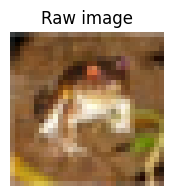

In [12]:
plt.figure(figsize=(2,2))

plt.imshow(raw_image)
plt.title('Raw image')
plt.axis('off')



**What is the length of the train set?**

In [14]:
# Trianing set has 50,000 images and test set has 10,000 images
# similar as List, dict, can use len() to get the length of the dataset
length_trainset =  len(train_dataset)
print("The length of the train set is", length_trainset)

The length of the train set is 50000


**Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**

  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [18]:
labels_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# after this step, can use labels_names[i] to convert the label i to the name of the class

The following code allows to visualize 8 images in each category

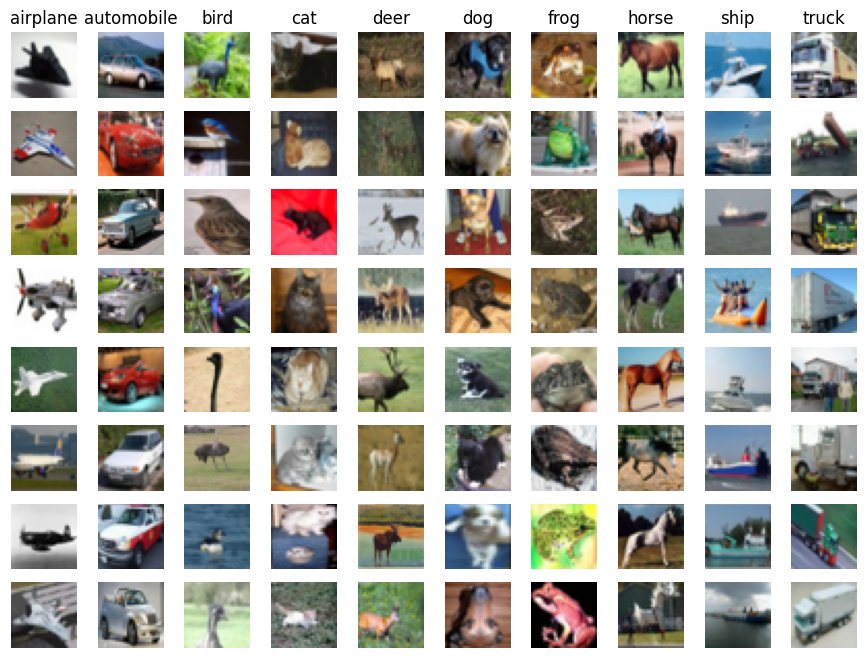

In [19]:
n = 8  # Number of images per class
f, axes = plt.subplots(n, 10, figsize=(11, 8))

for i in range(10):  # Iterate over the 10 classes
    count = 0
    j = 0
    while count < n and j < len(train_dataset):
        if train_dataset.targets[j] == i:
            axes[count, i].imshow(train_dataset.data[j])  # Show image
            axes[count, i].axis('off')
            if count == 0:
                axes[count, i].set_title(labels_names[i])  # Set title for first row
            count += 1
        j += 1

plt.show()



<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**Create a sequential model with 4 `Dense` hidden layers of 1024, 512, 256, and 100 nodes each, with ReLU activation, and an output layer suited for the learning task.**

In [21]:
import torch.nn as nn
import torch.nn.functional as F

input_dim = 3 * 32 * 32  # CIFAR-10 images are 32x32 with 3 color channels
hidden1_dim = 1024  # first hidden layer dimension (1024 neurons)
hidden2_dim = 512  # second hidden layer...
hidden3_dim = 256
hidden4_dim = 100
output_dim = 10  # CIFAR-10 has 10 classes

class DenseModel(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10):
        super(DenseModel, self).__init__()

        # Define here the layers that you want to add
        
        # from input layer to first hidden layer
        self.linear1 = nn.Linear(input_dim, hidden1_dim)
        # transform between hidden layers
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.linear3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.linear4 = nn.Linear(hidden3_dim, hidden4_dim)
        # from last hidden layer to output layer
        self.linear5 = nn.Linear(hidden4_dim, output_dim)





    def forward(self, x):
        # Flatten the input tensor to a 2D tensor (batch_size, input_dim)
        x = x.view(-1, input_dim)
        # Apply the activation function on each layer
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        # from last hidden layer to output layer (no need for activation function)
        y_pred = self.linear5(x)

        return  y_pred

# Create model instance
model = DenseModel()

print(model)


DenseModel(
  (linear1): Linear(in_features=3072, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=100, bias=True)
  (linear5): Linear(in_features=100, out_features=10, bias=True)
)


**Compute by hand the total number of trainable parameters (weights and biases) in the model.**

Detailed computations here:

First layer: (3 * 32 * 32) * 1024 + 1024 = 3146752  
Second layer: 1024 * 512 + 512 = 524800  
Third layer: 512 * 256 + 256 = 131328  
Fourth layer: 256 * 100 + 100 = 25700  
Output layer: 100 * 10 + 10 = 1010  
sum = 3829590

In [23]:
# Write here the total number of parameters
total_number_parameters_dense = 3829590

**Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [25]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from torchsummary import summary
summary(model.to(device), (3, 32, 32))  # Input shape: (Channels, Height, Width)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       3,146,752
            Linear-2                  [-1, 512]         524,800
            Linear-3                  [-1, 256]         131,328
            Linear-4                  [-1, 100]          25,700
            Linear-5                   [-1, 10]           1,010
Total params: 3,829,590
Trainable params: 3,829,590
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 14.61
Estimated Total Size (MB): 14.63
----------------------------------------------------------------


**Complete the next function.**

- **Define cross-entropy loss**

- **Training Loop: For each epoch, iterate over training batches to compute loss, perform backpropagation, update parameters.**

- **Validation: After each epoch, evaluate the model on the validation set.**


In [ ]:
from torch.nn.functional import cross_entropy
import torch.optim as optim

def train_model(model, optimizer, scheduler = None, epochs=10):

    # Define the loss function
    criterion = cross_entropy

    # Store the history
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    best_val_acc = 0.0

    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            ################## TODO BLOCK
            # set optimizer to zero grad to remove previous epoch gradients
            optimizer.zero_grad()
            # get outputs
            outputs = model(inputs)
            # compute loss
            loss = criterion(outputs, targets)
            # backward propagation
            loss.backward()
            # one optimization step
            optimizer.step()
            ################## END TODO BLOCK

            # Update of the scheduler at each iteration (non conventional)
            if scheduler is not None:
                scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            total_train += targets.size(0)
            train_acc += preds.eq(targets).sum().item()

        train_loss /= total_train
        train_acc = train_acc / total_train

        # Validation stage after each epoch
        model.eval()
        val_loss = 0.0
        val_acc = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # TODO OPERAND
                loss = criterion(outputs, targets)  # TODO OPERAND

                val_loss += loss.item() * inputs.size(0)
                _, preds = outputs.max(1)
                total_val += targets.size(0)
                val_acc += preds.eq(targets).sum().item()

        val_loss /= total_val
        val_acc = val_acc / total_val

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Check for best validation accuracy and save best weights
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())  # Save best model weights

        print(f"Epoch {epoch+1}/{epochs}  -  Train Loss: {train_loss:.4f}  Train Acc: {100*train_acc:.2f}%  -  Val Loss: {val_loss:.4f}  Val Acc: {100*val_acc:.2f}%")

    print(f"Best Validation Accuracy: {100*best_val_acc:.2f}%")

    return history, best_model_weights


**Test your DenseModel(). Use a torch.optim.SGD optimizer (you are free to choose the learning rate)**

In [28]:
model = DenseModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)  # TODO OPERAND
history, best_weights = train_model(model,optimizer)  # TODO OPERAND

Epoch 1/10  -  Train Loss: 2.2735  Train Acc: 16.35%  -  Val Loss: 2.2058  Val Acc: 24.02%
Epoch 2/10  -  Train Loss: 2.0770  Train Acc: 26.62%  -  Val Loss: 1.9494  Val Acc: 29.24%
Epoch 3/10  -  Train Loss: 1.8731  Train Acc: 32.51%  -  Val Loss: 1.7931  Val Acc: 34.91%
Epoch 4/10  -  Train Loss: 1.7456  Train Acc: 37.65%  -  Val Loss: 1.6839  Val Acc: 40.36%
Epoch 5/10  -  Train Loss: 1.6511  Train Acc: 40.99%  -  Val Loss: 1.6040  Val Acc: 43.04%
Epoch 6/10  -  Train Loss: 1.5767  Train Acc: 43.76%  -  Val Loss: 1.5521  Val Acc: 45.07%
Epoch 7/10  -  Train Loss: 1.5121  Train Acc: 46.17%  -  Val Loss: 1.4944  Val Acc: 47.18%
Epoch 8/10  -  Train Loss: 1.4525  Train Acc: 48.25%  -  Val Loss: 1.4850  Val Acc: 47.08%
Epoch 9/10  -  Train Loss: 1.3971  Train Acc: 50.44%  -  Val Loss: 1.4366  Val Acc: 50.31%
Epoch 10/10  -  Train Loss: 1.3470  Train Acc: 52.52%  -  Val Loss: 1.4572  Val Acc: 48.08%
Best Validation Accuracy: 50.31%


**Discuss the accuracy of your trained model. Is your model better than a random predictor?**

The best validation accuracy our the training model is 50.31%, clearly is better than a random predictor(10% accuracy of gussing from 10 classes). We can also see that, in the first half batches, the accuracy score increasing rapidly, but after that the accuarcy score increasing much slower. And after the 9th batch, the accuracy score start to decrease.


**The next cell introduces a scheduler. What is the reason for using a scheduler?**

The scheduler is used to **dynamically adjust the learning rate**, usually gradually decreasing it during training. This helps the model converge better in the later stages of training and **avoids missing the optimal solution**. A higher initial learning rate helps to converge quickly, while lowering the learning rate in the later stages allows the model to fine-tune the parameters more stably around the optimal point, **improving the final performance**. Here, it did improved our best validation accuracy from 50.31% to 51.05%. If with more epochs, the accuaracy may be improved more.


In [29]:
model = DenseModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
decay_rate = 0.9
decay_steps = 10000
# Define the scheduler，adjust learning rate after each epoch(batch)
# step represents how many times the optimizer.step() has been called
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights = train_model(model,optimizer,scheduler)

Epoch 1/10  -  Train Loss: 2.2372  Train Acc: 16.57%  -  Val Loss: 2.1232  Val Acc: 24.43%
Epoch 2/10  -  Train Loss: 2.0065  Train Acc: 27.51%  -  Val Loss: 1.9032  Val Acc: 30.93%
Epoch 3/10  -  Train Loss: 1.8410  Train Acc: 33.48%  -  Val Loss: 1.7677  Val Acc: 36.96%
Epoch 4/10  -  Train Loss: 1.7213  Train Acc: 38.43%  -  Val Loss: 1.6603  Val Acc: 40.64%
Epoch 5/10  -  Train Loss: 1.6281  Train Acc: 41.93%  -  Val Loss: 1.5860  Val Acc: 44.00%
Epoch 6/10  -  Train Loss: 1.5544  Train Acc: 44.73%  -  Val Loss: 1.5436  Val Acc: 45.60%
Epoch 7/10  -  Train Loss: 1.4911  Train Acc: 46.96%  -  Val Loss: 1.4908  Val Acc: 47.43%
Epoch 8/10  -  Train Loss: 1.4330  Train Acc: 49.13%  -  Val Loss: 1.4687  Val Acc: 48.11%
Epoch 9/10  -  Train Loss: 1.3822  Train Acc: 50.89%  -  Val Loss: 1.4173  Val Acc: 50.39%
Epoch 10/10  -  Train Loss: 1.3364  Train Acc: 52.68%  -  Val Loss: 1.3903  Val Acc: 51.05%
Best Validation Accuracy: 51.05%


**Initialization**: The next cell changes the way the initial weights of the model are computed. Have a look at the impact of the initialization method on the performance. Provide your comments.

Change initial weight refers to manually setting the initial values of the parameters (weights(W) and biases(b)) of each layer in the network before model training begins.
This approach helps ensure a more reasonable weight distribution, facilitates **better gradient propagation throughout the network**, and avoids issues such as gradient vanishing or exploding gradients, thereby **improving the model's training speed and final performance**. Howerver, here this method did not improve the performance and time, this may due to several reasons, for example, the model structure is shallow, training epochs is too less, the model itself, and so on.


In [30]:
import torch.nn.init as init

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)

model = DenseModel()
# Apply new initialization weights to every layer of the model
model.apply(init_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights = train_model(model,optimizer,scheduler)


Epoch 1/10  -  Train Loss: 1.8028  Train Acc: 36.01%  -  Val Loss: 1.6435  Val Acc: 42.77%
Epoch 2/10  -  Train Loss: 1.5440  Train Acc: 45.93%  -  Val Loss: 1.5426  Val Acc: 45.55%
Epoch 3/10  -  Train Loss: 1.4241  Train Acc: 50.08%  -  Val Loss: 1.4791  Val Acc: 48.19%
Epoch 4/10  -  Train Loss: 1.3326  Train Acc: 53.70%  -  Val Loss: 1.4642  Val Acc: 49.01%
Epoch 5/10  -  Train Loss: 1.2525  Train Acc: 56.66%  -  Val Loss: 1.4573  Val Acc: 48.78%
Epoch 6/10  -  Train Loss: 1.1772  Train Acc: 59.18%  -  Val Loss: 1.4277  Val Acc: 50.58%
Epoch 7/10  -  Train Loss: 1.1097  Train Acc: 62.02%  -  Val Loss: 1.4987  Val Acc: 48.25%
Epoch 8/10  -  Train Loss: 1.0443  Train Acc: 64.10%  -  Val Loss: 1.4652  Val Acc: 49.66%
Epoch 9/10  -  Train Loss: 0.9780  Train Acc: 66.65%  -  Val Loss: 1.4453  Val Acc: 50.98%
Epoch 10/10  -  Train Loss: 0.9143  Train Acc: 68.90%  -  Val Loss: 1.4843  Val Acc: 49.66%
Best Validation Accuracy: 50.98%


**Inspect the output of the model for a given input sample : provide its shape.**

In [31]:
j=0
image , true_label = test_dataset[j]
image = image.to(device)
output = model(image.unsqueeze(0))
##################### TODO BLOCK
print ('Output Shape: ', output.shape)

##################### END TODO BLOCK

Output Shape:  torch.Size([1, 10])


**Does the ouput of the model represent the probabilities of each class?**

No the output of the model is not the probabilities of each class, it is the logits of each class. This is normal, because I used the cross_entropy loss function, it automatically applied the softmax function inside.

**For the first image of the test set, compute the predicted label in 0,1,...9**

In [35]:
j=0
# dataset[j] returns (image, label) where, image is a tensor and label is the class_num
image , true_label = test_dataset[j]
image = image.to(device)

output = model(image.unsqueeze(0))
# Finds the index of the maximum value in the first dimension of the tensor (usually the category dimension)
pred = output.argmax(dim=1)

message = ["Test sample : ",j, ", Label : ",true_label,", Prediction : ", pred.item()]
print(message)

['Test sample : ', 0, ', Label : ', 3, ', Prediction : ', 3]


**Plot eight images in each category, and check the corresponding predictions. Provide your comments.**

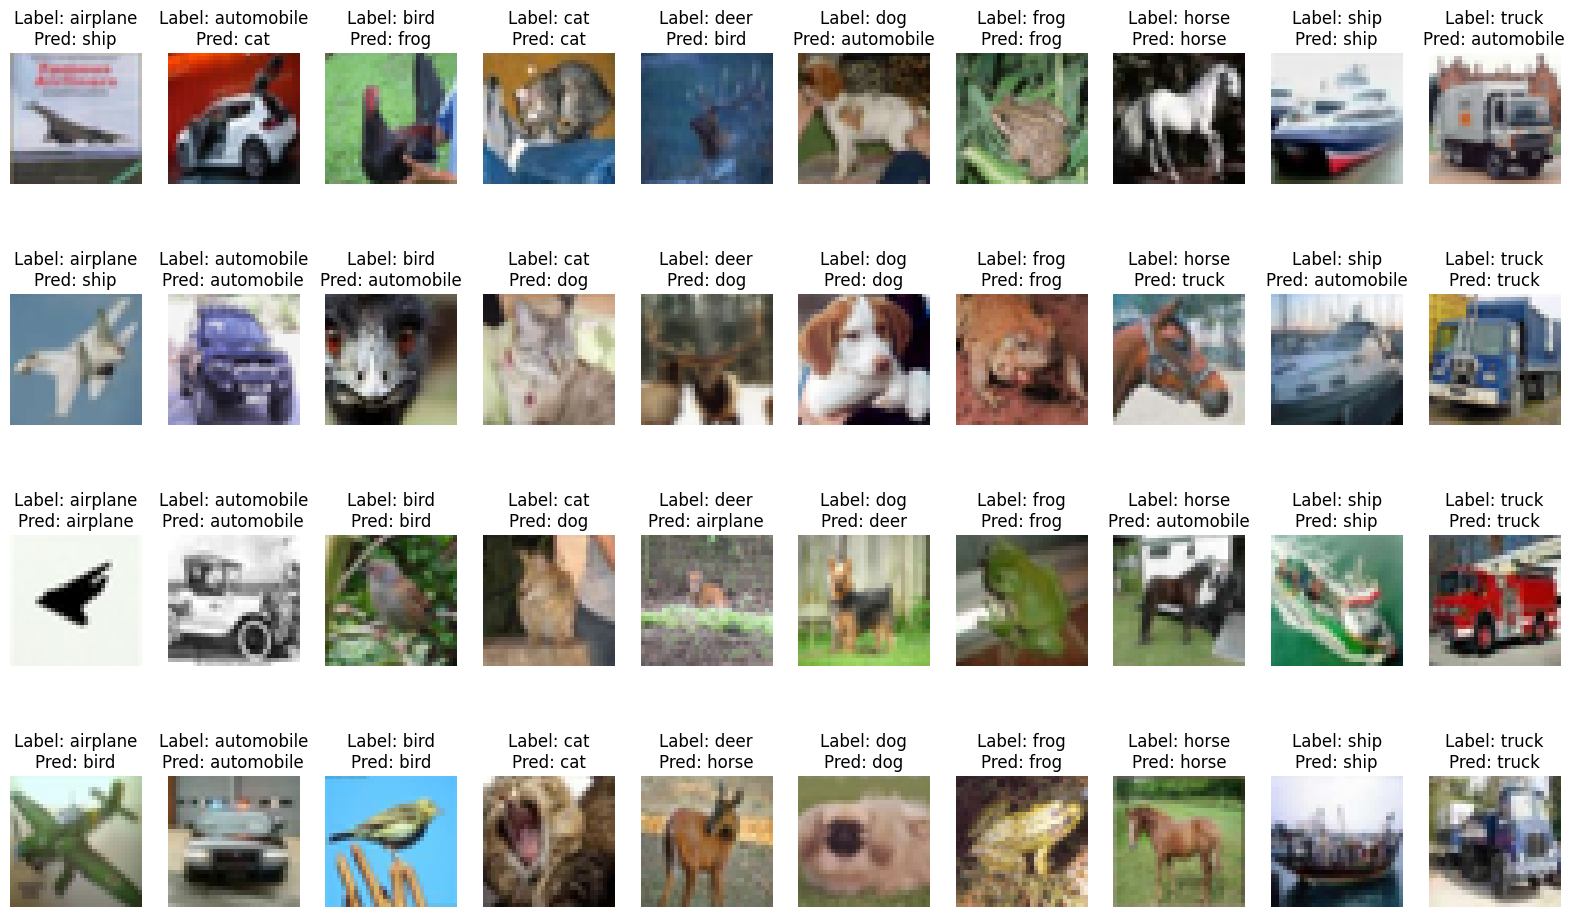

In [ ]:
f, axes = plt.subplots(4, 10, figsize=(20, 12))
model.eval()

for i in range(10):  # Iterate over the 10 classes
    count = 0
    j = 0
    while count < 4:
        if test_dataset.targets[j] == i:
            axes[count, i].imshow(test_dataset.data[j])
            image , _ = test_dataset[j]
            image = image.to(device)
            output = model(image.unsqueeze(0))
            pred = output.argmax(dim = 1)
            axes[count, i].set_title("Label: "+ labels_names[i] + '\n' + "Pred: " + labels_names[pred.item()])
            axes[count, i].axis('off')
            count += 1
        j += 1

plt.show()

# According to the results, the prediction results are along with the accuracy, around 50% are correct.

<a id='cnn'></a>

# 3 - Convolutional Neural Network


Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='handcrafted features'></a>
## 3.1 - Visualize 2D-convolution of an image

We will first investigate the effect of using a convolutional layer on the image, with a single filter/kernel applied to each color channel. The following functions allows to define a taylored convolutional layer, and to vizualize the output. Nothing is required from your side, just run the cell.


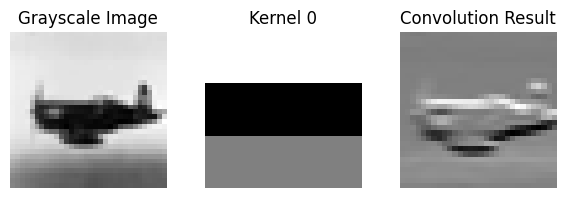

In [37]:
kernel = torch.Tensor([[1, 1, 1],[-1, -1, -1],[0, 0, 0]])  # TODO OPERAND
model = FixedKernels_processing(kernel)
image,_ = train_dataset[115]
model.visualize(image = image)

Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)




**Define your own kernel of shape (3,3), specialized in the detection of horizontal lines in an image**

**Same question, but this time use a kernel specialized in the detection of vertical lines**

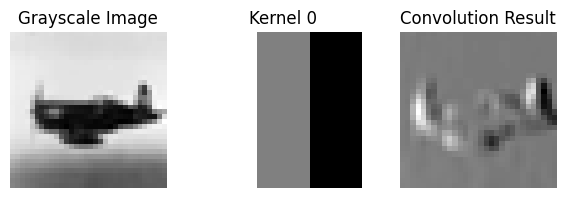

In [39]:
# left column is all one , middle 0, right are all -1. Use to detect vertical lines and vertical edges
# if to detect horizontal lines and horizontal edges, use kernel = torch.Tensor([1, 1, 1], [0, 0, 0], [-1, -1, -1])
kernel = torch.Tensor([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
FixedKernels_processing(kernel).visualize(image = image)

**The following cell allows to vizualise the effect of various filters on the image. Comment on the effect of the filters that are used**

From the convolution results, we can see that **each filter extracts specific structural information** from the original image, such as outlines and boundaries. This demonstrates how convolutional kernels **help neural networks capture important features** for image classification.




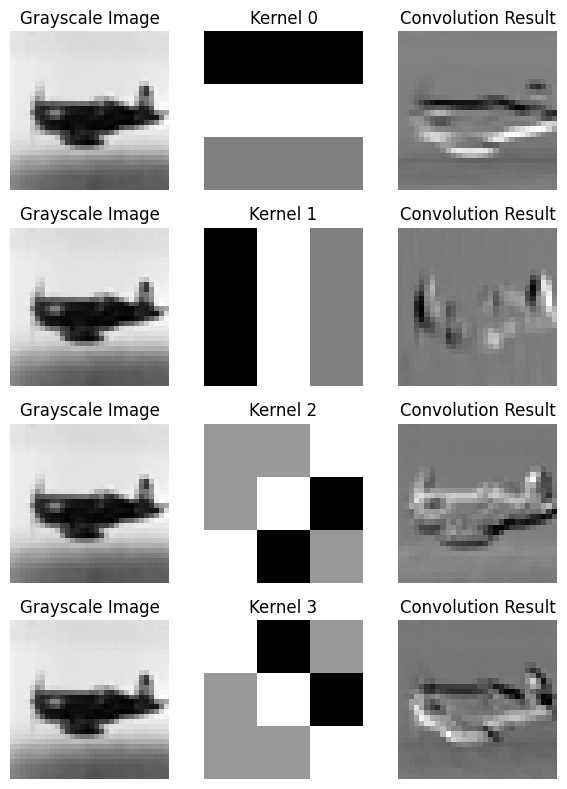

In [40]:
top=np.array([[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]],dtype=np.float32)

straights = [ torch.Tensor(np.rot90(top, i).copy()) for i in range(2) ]

br=[[ 0,   0,   1],
    [ 0,   1,-1.5],
    [ 1,-1.5,   0]]
diags = [ torch.Tensor(np.rot90(br, i).copy()) for i in range(2) ]

kernels = straights+diags

preprocessing = FixedKernels_processing(kernels)

preprocessing.visualize(image = image)


We will use these features as a preprocessing.

**Define a model which first applies the previously defined** `preprocessing` **model as a preprocessing applied to the input images. Then, apply a relu. Next, add a MaxPooling2D layer using** `nn.MaxPool2d(kernel_size=2, stride=2)`. **Flatten the result and add a final dense layer.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class handcrafted_model(nn.Module):
    def __init__(self, preprocessing = preprocessing, num_classes=10):

        super(handcrafted_model, self).__init__()

        # applying kernal to the input image
        # have four kernels, two digonal and two straight
        # after convolution => the size is (32-3)/1 + 1 = 30
        self.preprocessing = preprocessing

        # ReLU Layer
        self.relu = nn.ReLU()

        # MaxPooling Layer, the output of convolution is 15*15 for each kernel
        # after pooling form the convolution => the size is (30-2)/2 + 1 = 15
        # thus the size of the output for each kernel is 15*15
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layer (after flattening)
        input_dim = 4*15*15 # 4 kernels, 15*15 for each kernel
        output_dim = num_classes
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):

        if x.ndim != 4:
            raise ValueError("Input must be a 4D tensor of shape [N, C, H, W].")

        # Apply the preprocessing
        x = self.preprocessing(x)

        # Apply ReLU activation
        x = self.relu(x)

        # Apply MaxPooling
        x = self.pool(x)

        # Flatten the result
        x = torch.flatten(x, start_dim=1)

        # Apply fully connected layer
        x = self.fc(x)

        return x

model = handcrafted_model()

number_param = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {number_param}")

# total parameters are siginificant less than our previous model, represent pooling and fully connected layers

Total parameters: 9046


**Train the model and provide your comments**

The handcrafted_model performs significantly better than random guessing (10%) on CIFAR-10, but is far below our previous models. This indicates that the model extracts limited features and has insufficient expressive power when relying solely on simple handcrafted convolutional kernels and a fully connected layer.


In [45]:
model = handcrafted_model()
model.apply(init_weights)

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights = train_model(model, optimizer, scheduler)


Epoch 1/10  -  Train Loss: 2.1503  Train Acc: 22.47%  -  Val Loss: 2.0524  Val Acc: 26.69%
Epoch 2/10  -  Train Loss: 2.0271  Train Acc: 28.32%  -  Val Loss: 1.9994  Val Acc: 30.11%
Epoch 3/10  -  Train Loss: 1.9918  Train Acc: 30.10%  -  Val Loss: 1.9788  Val Acc: 30.58%
Epoch 4/10  -  Train Loss: 1.9704  Train Acc: 31.09%  -  Val Loss: 1.9626  Val Acc: 31.44%
Epoch 5/10  -  Train Loss: 1.9555  Train Acc: 31.87%  -  Val Loss: 1.9569  Val Acc: 31.65%
Epoch 6/10  -  Train Loss: 1.9431  Train Acc: 32.48%  -  Val Loss: 1.9480  Val Acc: 32.37%
Epoch 7/10  -  Train Loss: 1.9334  Train Acc: 32.99%  -  Val Loss: 1.9392  Val Acc: 33.23%
Epoch 8/10  -  Train Loss: 1.9243  Train Acc: 33.46%  -  Val Loss: 1.9351  Val Acc: 32.90%
Epoch 9/10  -  Train Loss: 1.9171  Train Acc: 33.69%  -  Val Loss: 1.9299  Val Acc: 33.18%
Epoch 10/10  -  Train Loss: 1.9100  Train Acc: 34.03%  -  Val Loss: 1.9211  Val Acc: 33.64%
Best Validation Accuracy: 33.64%


<a id='first_cnn'></a>
## 3.2 - Create your first CNN

**Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero-padding, a stride of 1, 8 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, a stride of 1, 8 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - 3x3 2D convolution, with zero-padding, a stride of 1, 32 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, a stride of 1, 32 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - Flatten
  - Dense layer with 408 nodes, ReLU activation
  - A well-chosen output layer

In [48]:
class CnnModel(nn.Module):
    def __init__(self, input_shape=(3,32,32), num_classes=10):

        super(CnnModel, self).__init__()

        ################# TODO BLOCK
        # there are 4 convolutional layers
        # nn.Cov2d(in_channels, out_channels, kernel_size, stride=1, padding=0, padding_mode='zeros')
        # in_channels for the first layer is 3 (depends on the image)
        # ouput channels is the number of filters (also the input to next layer)
        self.cov1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1) # with padding prevent the image size, output is 3*32*32
        self.cov2 = nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=0) # without padding, image size become (32-3)/1 + 1 = 30, output size is 8*30*30
        
        # after the first pooling, size become 8*15*15
        self.cov3 = nn.Conv2d(8, 32, kernel_size=3, stride=1, padding=1) # with padding, output is 32*15*15
        self.cov4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0) # without padding, output is 32*13*13

        # after the last pooling output is 32*6*6
        # fully connected layer(after flattening the output of the last convolutional layer)
        # the dense layer have 408 neurons
        self.fc1 = nn.Linear(32*6*6, 408)
        self.fc2 = nn.Linear(408, num_classes) # forward to the output layer

        # Max pooling with size 2x2 and stride of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # activiation function ReLU
        self.relu = nn.ReLU()

        ################# END TODO BLOCK


    def forward(self, x):

        ################# TODO BLOCK
        x = self.relu(self.cov1(x))
        x = self.relu(self.cov2(x))
        x = self.pool(x)
        x = self.relu(self.cov3(x))
        x = self.relu(self.cov4(x))
        x = self.pool(x)

        # flatten
        x = torch.flatten(x, start_dim=1)

        # forward to dense layer
        x = self.relu(self.fc1(x))
        # forward to output layer
        x = self.fc2(x)
        ################# END TODO BLOCK

        return x

cnn = CnnModel()

**Compute by hand the number of trainable parameters in this network.  Are there more or less than the simple dense network of section 1?  Why?**

First convolutional layer: (3 * 3 * 3 * 8) + 8 = 224  
Second convolutional layer: (8 * 3 * 3 * 8) + 8 = 584  
Third convolutional layer: (8 * 3 * 3 * 32) + 32 = 2336  
Fourth convolutional layer: (32 * 3 * 3 * 32) + 32 = 9248  
dense layer: (32 * 6 * 6 * 408) + 408 = 470424  
ouput layer: 408 * 10 + 10 = 4090
sum = 224 + 584 + 2336 + 9248 + 470424 + 4090 = 486906  
In section 1, the total trainable parameters are 3829590, and here is 486906.Thus, the number of trainable parameters for this CNN is significantly less than the simple dense network in section 1.  
The same convolution kernel slides across the entire image, using the same set of parameters for all positions. Therefore, **the number of parameters only depends on the size of the convolution kernel and the number of channels, and is independent of the size of the input image**.  
Convolutional layers **only focus on local areas at a time**, rather than connecting each neuron to all neurons in the previous layer like fully connected layers, greatly reducing the number of parameters.

In [52]:
# Put here the result of your computation
total_number_parameters_cnn = 486906

 **Confirm with** `summary()`

In [51]:
################## TODO BLOCK
summary(cnn.to(device), (3, 32, 32))

################## END TODO BLOCK

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
              ReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3            [-1, 8, 30, 30]             584
              ReLU-4            [-1, 8, 30, 30]               0
         MaxPool2d-5            [-1, 8, 15, 15]               0
            Conv2d-6           [-1, 32, 15, 15]           2,336
              ReLU-7           [-1, 32, 15, 15]               0
            Conv2d-8           [-1, 32, 13, 13]           9,248
              ReLU-9           [-1, 32, 13, 13]               0
        MaxPool2d-10             [-1, 32, 6, 6]               0
           Linear-11                  [-1, 408]         470,424
             ReLU-12                  [-1, 408]               0
           Linear-13                   [-1, 10]           4,090
Total params: 486,906
Trainable params:

**Train the network for 10 epochs. How does the validation accuracy change with each epoch?**

In [ ]:
################## TODO BLOCK
model = CnnModel()
model.apply(init_weights)

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights = train_model(model, optimizer, scheduler)

################## END TODO BLOCK

Epoch 1/10  -  Train Loss: 1.9920  Train Acc: 28.36%  -  Val Loss: 1.7891  Val Acc: 36.95%
Epoch 2/10  -  Train Loss: 1.6796  Train Acc: 39.78%  -  Val Loss: 1.5922  Val Acc: 42.71%
Epoch 3/10  -  Train Loss: 1.5287  Train Acc: 45.52%  -  Val Loss: 1.4876  Val Acc: 46.21%
Epoch 4/10  -  Train Loss: 1.4441  Train Acc: 48.69%  -  Val Loss: 1.4120  Val Acc: 49.48%
Epoch 5/10  -  Train Loss: 1.3809  Train Acc: 51.02%  -  Val Loss: 1.4063  Val Acc: 50.17%
Epoch 6/10  -  Train Loss: 1.3194  Train Acc: 53.30%  -  Val Loss: 1.3429  Val Acc: 52.27%
Epoch 7/10  -  Train Loss: 1.2647  Train Acc: 55.32%  -  Val Loss: 1.2777  Val Acc: 55.59%
Epoch 8/10  -  Train Loss: 1.2098  Train Acc: 57.51%  -  Val Loss: 1.2143  Val Acc: 57.94%
Epoch 9/10  -  Train Loss: 1.1605  Train Acc: 59.48%  -  Val Loss: 1.1686  Val Acc: 59.52%
Epoch 10/10  -  Train Loss: 1.1184  Train Acc: 61.11%  -  Val Loss: 1.1610  Val Acc: 59.58%
Best Validation Accuracy: 59.58%


**Plot the evolution of (train/val) accuracy through epochs**

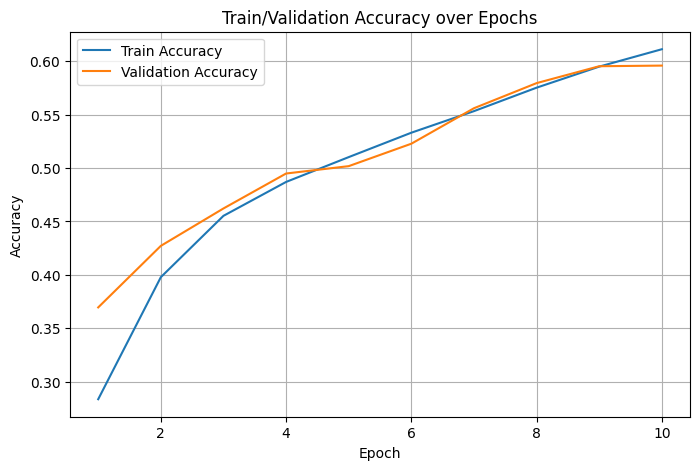

In [54]:

################## TODO BLOCK
epochs = range(1, len(history["train_acc"]) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, history["train_acc"], label='Train Accuracy')
plt.plot(epochs, history["val_acc"], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()
################## END TODO BLOCK



**Consider now a batch size of 32 and consider the above CNN. Try adding 3 BatchNormalization layers to this model, one after each max-pooling layer and one before the last layer. Use a dropout layer just before the last linear layer.**

In [60]:
################## TODO BLOCK
# change the batch size to 32 (originally 128)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=pin_memory)


class CnnModelBN(nn.Module):
    def __init__(self, input_shape=(3,32,32), num_classes=10):

        super(CnnModelBN, self).__init__()

        ################# TODO BLOCK
        # there are 4 convolutional layers
        # nn.Cov2d(in_channels, out_channels, kernel_size, stride=1, padding=0, padding_mode='zeros')
        self.cov1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1) # with padding prevent the image size, output is 3*32*32
        self.cov2 = nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=0) # without padding, image size become (32-3)/1 + 1 = 30, output size is 8*30*30
        
        # after the first pooling, size become 8*15*15
        # add a batch normolization layer after first pooling 
        self.bn1 = nn.BatchNorm2d(8)

        self.cov3 = nn.Conv2d(8, 32, kernel_size=3, stride=1, padding=1) # with padding, output is 32*15*15
        self.cov4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0) # without padding, output is 32*13*13

        # after the last pooling output is 32*6*6
        # add a batch normolization layer after the second pooling
        self.bn2 = nn.BatchNorm2d(32)

        # fully connected layer(after flattening the output of the last convolutional layer)
        # the dense layer have 408 neurons
        self.fc1 = nn.Linear(32*6*6, 408)

        # add a batch normolization before the last layer (use 1d, because flattened already)
        self.bn3 = nn.BatchNorm1d(408)
        # add a dropout layer (avoid over fitting)
        self.dropout = nn.Dropout(p=0.5) # 50% prob radom block neurons

        self.fc2 = nn.Linear(408, num_classes) # forward to the output layer

        # Max pooling with size 2x2 and stride of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # activiation function ReLU
        self.relu = nn.ReLU()

        ################# END TODO BLOCK


    def forward(self, x):

        ################# TODO BLOCK
        x = self.relu(self.cov1(x))
        x = self.relu(self.cov2(x))
        x = self.pool(x)

        # applying the batch normalization
        x = self.bn1(x)

        x = self.relu(self.cov3(x))
        x = self.relu(self.cov4(x))
        x = self.pool(x)

        # applying the batch normalization
        x = self.bn2(x)

        # flatten
        x = torch.flatten(x, start_dim=1)

        # forward to dense layer
        x = self.relu(self.fc1(x))

        # applying the last batch normalization
        x = self.bn3(x)

        # dropout layer
        x = self.dropout(x)

        # forward to output layer
        x = self.fc2(x)
        ################# END TODO BLOCK

        return x

cnn_bn = CnnModelBN()

################## END TODO BLOCK

**Train the model. What is the impact of batch normalization on the model's performance? Why?**

The model training time shrinked around 10 times to the original.  
The performance has improved 10% on the accuracy.  
The reasons are: It accelerates the training process by normalizing the input to each layer, so the model **converged faster**.  
It also adds **noise** to each batch, which act like **regularization** and **reduce overfitting**.


In [61]:
################## TODO BLOCK
model_bn = CnnModelBN()
model_bn.apply(init_weights)

optimizer = torch.optim.SGD(model_bn.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history_bn, best_weights_bn = train_model(model_bn, optimizer, scheduler)

################## END TODO BLOCK

Epoch 1/10  -  Train Loss: 1.7911  Train Acc: 40.61%  -  Val Loss: 1.3028  Val Acc: 53.36%
Epoch 2/10  -  Train Loss: 1.3026  Train Acc: 53.95%  -  Val Loss: 1.1403  Val Acc: 59.53%
Epoch 3/10  -  Train Loss: 1.1702  Train Acc: 58.39%  -  Val Loss: 1.0717  Val Acc: 61.77%
Epoch 4/10  -  Train Loss: 1.0874  Train Acc: 61.47%  -  Val Loss: 1.0051  Val Acc: 64.89%
Epoch 5/10  -  Train Loss: 1.0251  Train Acc: 63.78%  -  Val Loss: 0.9400  Val Acc: 66.45%
Epoch 6/10  -  Train Loss: 0.9738  Train Acc: 65.65%  -  Val Loss: 0.9141  Val Acc: 67.98%
Epoch 7/10  -  Train Loss: 0.9344  Train Acc: 67.35%  -  Val Loss: 0.9113  Val Acc: 68.50%
Epoch 8/10  -  Train Loss: 0.9025  Train Acc: 68.26%  -  Val Loss: 0.8761  Val Acc: 69.59%
Epoch 9/10  -  Train Loss: 0.8694  Train Acc: 69.43%  -  Val Loss: 0.8517  Val Acc: 70.39%
Epoch 10/10  -  Train Loss: 0.8414  Train Acc: 70.60%  -  Val Loss: 0.8315  Val Acc: 70.40%
Best Validation Accuracy: 70.40%


**Plot the evolution of (train/val) accuracy through epochs**

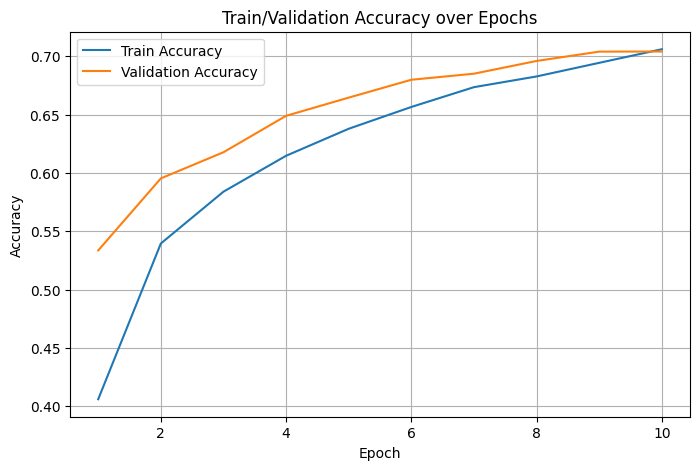

In [63]:

################## TODO BLOCK
epochs = range(1, len(history_bn["train_acc"]) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, history_bn["train_acc"], label='Train Accuracy')
plt.plot(epochs, history_bn["val_acc"], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()
################## END TODO BLOCK




<a id='results'></a>

## 3.3 - Study the predictions

**Consider image number 3 in the test set. Display the image and the output probabilities associated to each category**

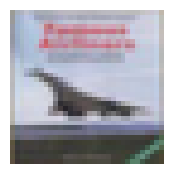

{'airplane': 0.7139854431152344, 'automobile': 0.020932890474796295, 'bird': 0.015868252143263817, 'cat': 0.0007414855062961578, 'deer': 0.0032996642403304577, 'dog': 0.00029744510538876057, 'frog': 0.0004267583426553756, 'horse': 0.00025781357544474304, 'ship': 0.24070413410663605, 'truck': 0.003486071014776826}


In [66]:
# Load the best weights and set the model to evaluation mode
cnn.load_state_dict(best_weights)  # Use the best weights
cnn.to(device)
cnn.eval()

i_sample = 3

# Retrieve the transformed image and label from the test dataset
image, label = test_dataset[i_sample]
image = image.to(device)

# Add a batch dimension and compute the model's output
output = cnn(image.unsqueeze(0))

# Apply softmax to get output probabilities
softmax = torch.nn.Softmax(dim=1)
output_proba = softmax(output)

# Display the raw image (from the original dataset data)
raw_image = test_dataset.data[i_sample]
plt.figure(figsize=(2,2))
plt.imshow(raw_image)
plt.axis("off")
plt.show()

# Create a dictionary mapping label names to their probability
dictionnary = {labels_names[i]: output_proba.squeeze()[i].item() for i in range(10)}
print(dictionnary)



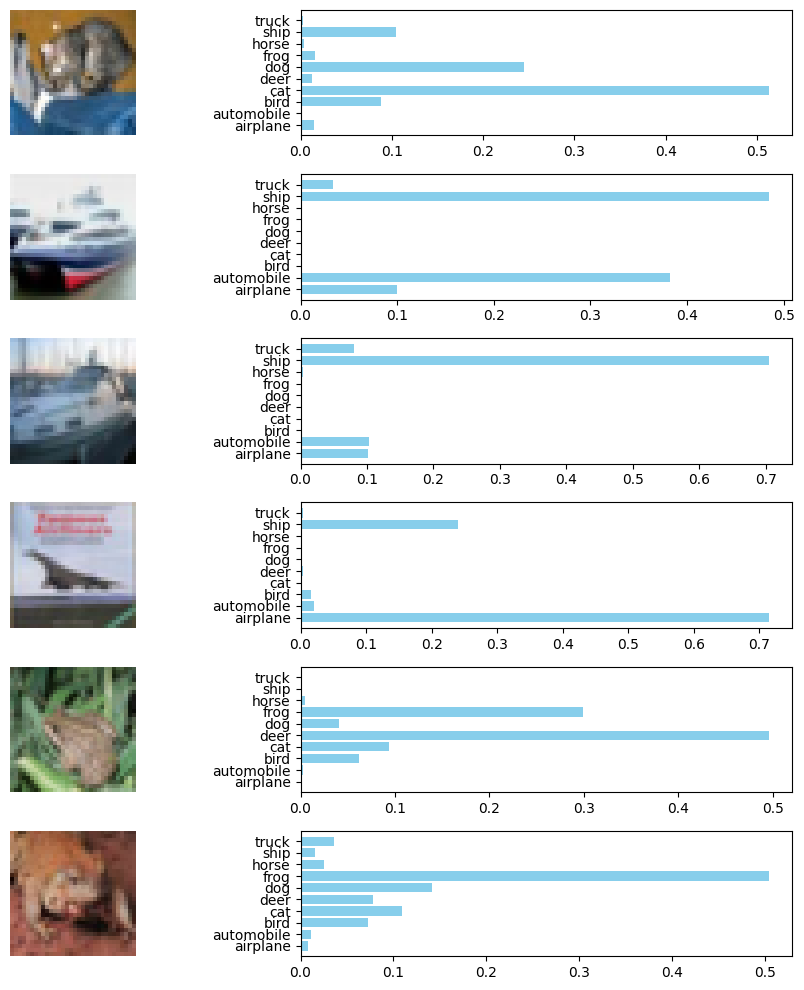

In [67]:
# Plot an image and the corresponding output probabilities of a given model.

plot_proba_from_model(cnn, test_dataset, range(6),device)

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement.

**Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

In [72]:
%pip install scikit-learn

  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   ----------------------- ---------------- 6.3/10.7 MB 35.1 MB/s eta 0:00:01
   ---------------------------------------- 10.7/10.7 MB 41.8 MB/s eta 0:00:00
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- --

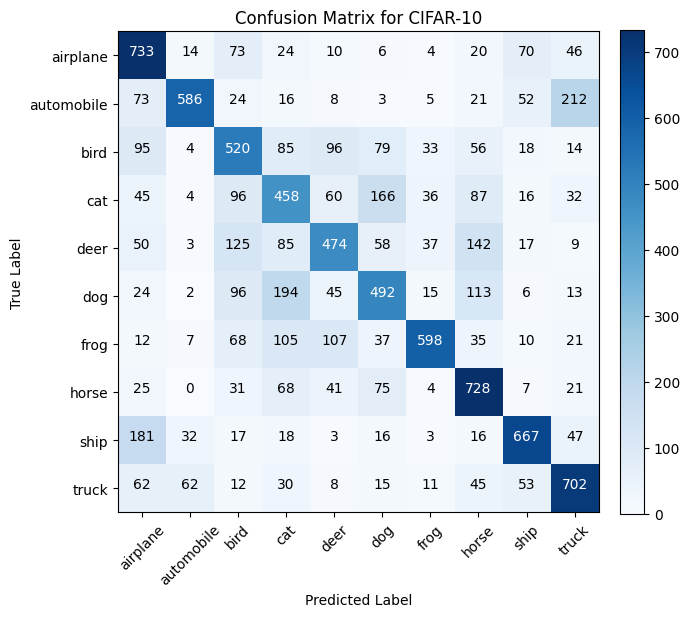

In [73]:
import sklearn.metrics as metrics

cnn.to(device)

# Set the model to evaluation mode
cnn.eval()

all_preds = []
all_labels = []

# Collect all predictions and true labels
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = cnn(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix using scikit-learn
cm = metrics.confusion_matrix(all_labels, all_preds)

plot_confusion_matrix(cm)



## 3.4 Try different optimizers

**You may compare the current model (trained with SGD and exponential scheduler) with the Adam optimizer (with and without scheduler)**. You may also consider other algorithms if you wish (RMSprop, Adagrad, for instance).

### (1) Adam optimizer without scheduler

### From the results, When using the Adam optimizer, the results curve differs significantly from SGD.  
Adam automatically adjusts the learning rate for each parameter, allowing it to adapt more quickly to different parameter update requirements. This allows the model to converge quickly in the early stages of training, but may also cause oscillation or stagnation in the later stages.

In [74]:
################## TODO BLOCK
model1 = CnnModelBN()
model1.apply(init_weights)

optimizer = torch.optim.Adam(model1.parameters(), lr=1e-2)
history_bn, best_weights_bn = train_model(model_bn, optimizer, scheduler)
################## END TODO BLOCK


Epoch 1/10  -  Train Loss: 0.7982  Train Acc: 71.86%  -  Val Loss: 0.8286  Val Acc: 70.93%
Epoch 2/10  -  Train Loss: 0.7956  Train Acc: 72.16%  -  Val Loss: 0.8335  Val Acc: 70.59%
Epoch 3/10  -  Train Loss: 0.8014  Train Acc: 71.97%  -  Val Loss: 0.8289  Val Acc: 70.53%
Epoch 4/10  -  Train Loss: 0.7977  Train Acc: 72.10%  -  Val Loss: 0.8307  Val Acc: 70.59%
Epoch 5/10  -  Train Loss: 0.8022  Train Acc: 71.78%  -  Val Loss: 0.8325  Val Acc: 70.50%
Epoch 6/10  -  Train Loss: 0.7979  Train Acc: 72.12%  -  Val Loss: 0.8344  Val Acc: 70.70%
Epoch 7/10  -  Train Loss: 0.7973  Train Acc: 72.00%  -  Val Loss: 0.8283  Val Acc: 70.69%
Epoch 8/10  -  Train Loss: 0.7978  Train Acc: 72.14%  -  Val Loss: 0.8283  Val Acc: 70.60%
Epoch 9/10  -  Train Loss: 0.8040  Train Acc: 71.74%  -  Val Loss: 0.8357  Val Acc: 70.51%
Epoch 10/10  -  Train Loss: 0.7999  Train Acc: 71.95%  -  Val Loss: 0.8319  Val Acc: 70.67%
Best Validation Accuracy: 70.93%


**Plot the evolution of (train/val) accuracy through epochs**

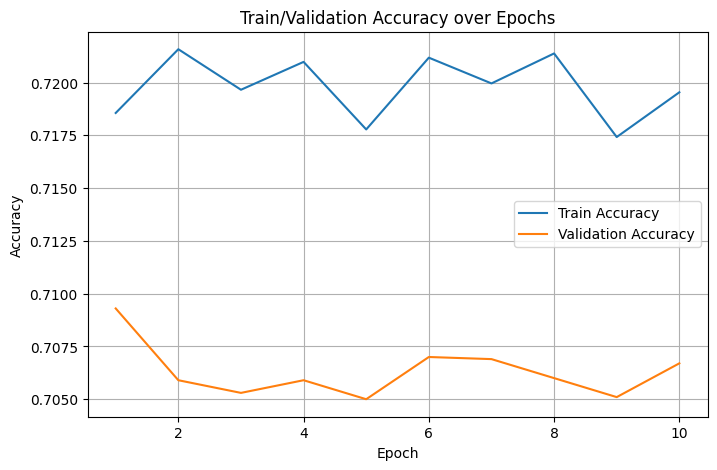

In [ ]:
################## TODO BLOCK
epochs = range(1, len(history_bn["train_acc"]) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, history_bn["train_acc"], label='Train Accuracy')
plt.plot(epochs, history_bn["val_acc"], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()
################## END TODO BLOCK

## the curve does not show improvement according to each epoch, the accuray socres are fluctuated around 70%.



### (2) Adam optimizer with scheduler

In [76]:
model2 = CnnModelBN()
model2.apply(init_weights)

optimizer = torch.optim.Adam(model1.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history_bn, best_weights_bn = train_model(model_bn, optimizer, scheduler)

Epoch 1/10  -  Train Loss: 0.7945  Train Acc: 72.30%  -  Val Loss: 0.8306  Val Acc: 70.53%
Epoch 2/10  -  Train Loss: 0.7985  Train Acc: 71.95%  -  Val Loss: 0.8283  Val Acc: 70.65%
Epoch 3/10  -  Train Loss: 0.7960  Train Acc: 71.94%  -  Val Loss: 0.8297  Val Acc: 70.95%
Epoch 4/10  -  Train Loss: 0.7969  Train Acc: 72.19%  -  Val Loss: 0.8295  Val Acc: 70.69%
Epoch 5/10  -  Train Loss: 0.7939  Train Acc: 72.10%  -  Val Loss: 0.8281  Val Acc: 70.68%
Epoch 6/10  -  Train Loss: 0.7967  Train Acc: 72.00%  -  Val Loss: 0.8300  Val Acc: 70.65%
Epoch 7/10  -  Train Loss: 0.7984  Train Acc: 71.94%  -  Val Loss: 0.8288  Val Acc: 70.67%
Epoch 8/10  -  Train Loss: 0.7987  Train Acc: 72.03%  -  Val Loss: 0.8295  Val Acc: 70.64%
Epoch 9/10  -  Train Loss: 0.7984  Train Acc: 72.02%  -  Val Loss: 0.8293  Val Acc: 70.61%
Epoch 10/10  -  Train Loss: 0.7973  Train Acc: 71.87%  -  Val Loss: 0.8284  Val Acc: 70.74%
Best Validation Accuracy: 70.95%


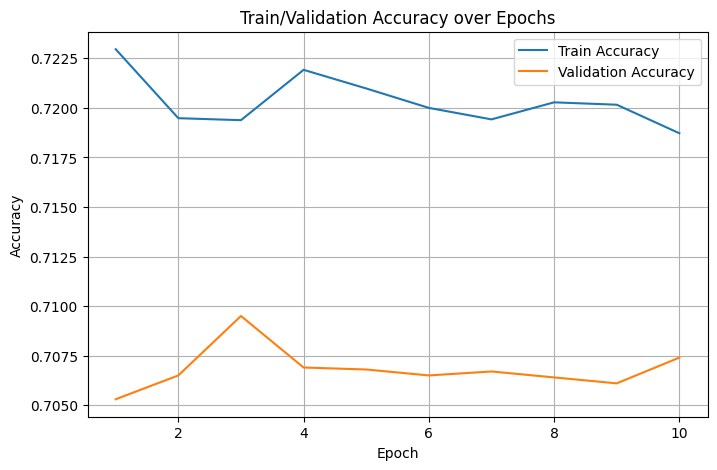

In [ ]:
epochs = range(1, len(history_bn["train_acc"]) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, history_bn["train_acc"], label='Train Accuracy')
plt.plot(epochs, history_bn["val_acc"], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# the training and test results look similar as the one without scheduler


### (3) Adam optimizer with scheduler and lower initial learning rate

In [78]:
model3 = CnnModelBN()
model3.apply(init_weights)

optimizer = torch.optim.Adam(model1.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history_bn, best_weights_bn = train_model(model_bn, optimizer, scheduler)

Epoch 1/10  -  Train Loss: 0.7934  Train Acc: 71.92%  -  Val Loss: 0.8282  Val Acc: 70.67%
Epoch 2/10  -  Train Loss: 0.7958  Train Acc: 72.01%  -  Val Loss: 0.8295  Val Acc: 70.56%
Epoch 3/10  -  Train Loss: 0.7949  Train Acc: 72.10%  -  Val Loss: 0.8275  Val Acc: 70.71%
Epoch 4/10  -  Train Loss: 0.7987  Train Acc: 71.79%  -  Val Loss: 0.8288  Val Acc: 70.59%
Epoch 5/10  -  Train Loss: 0.7958  Train Acc: 71.96%  -  Val Loss: 0.8331  Val Acc: 70.79%
Epoch 6/10  -  Train Loss: 0.8006  Train Acc: 71.90%  -  Val Loss: 0.8326  Val Acc: 70.39%
Epoch 7/10  -  Train Loss: 0.7993  Train Acc: 72.04%  -  Val Loss: 0.8287  Val Acc: 70.66%
Epoch 8/10  -  Train Loss: 0.8008  Train Acc: 72.07%  -  Val Loss: 0.8341  Val Acc: 70.50%
Epoch 9/10  -  Train Loss: 0.7981  Train Acc: 71.98%  -  Val Loss: 0.8285  Val Acc: 70.79%
Epoch 10/10  -  Train Loss: 0.8010  Train Acc: 71.75%  -  Val Loss: 0.8279  Val Acc: 70.71%
Best Validation Accuracy: 70.79%


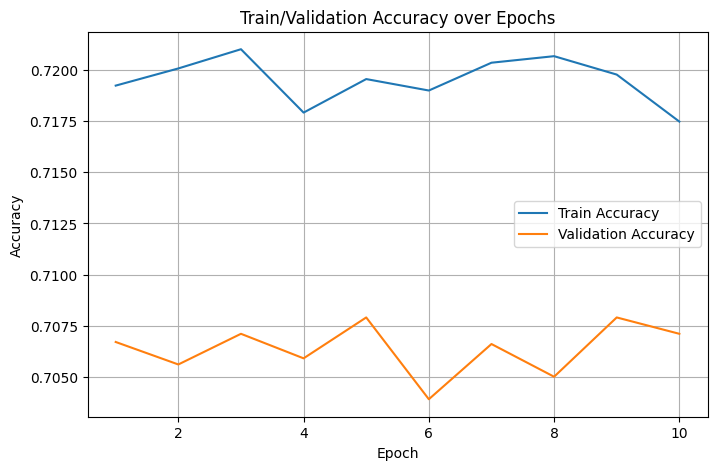

In [79]:
epochs = range(1, len(history_bn["train_acc"]) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, history_bn["train_acc"], label='Train Accuracy')
plt.plot(epochs, history_bn["val_acc"], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks

Several pre-trained networks are directly accessible via keras.

**Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10. You will:**


*   Download a model from `torchvision.models`.
*   Print its summary, understand its architecture.
*   If any, identify the layer(s) which play the role of a classifier, as opposed to the layers used for feature extraction.
*   Modify the model so that it ouputs the correct number of classes.
*   If the model has a large number of trainable parameters, you may consider freezing the feacture extraction layers (= make them non-trainable), only optimizing the last dense layers.
*   Train the model



In [ ]:
# Define the model and inspect its summary
import torchvision.models as models
from torchsummary import summary

################## TODO BLOCK
model_pt = models.resnet18(pretrained=True)

summary(model_pt.to(device), (3, 224, 224))
################## END TODO BLOCK


C:\Users\24991\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\24991\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [83]:
# Modify the model to output 10 classes for CIFAR‑10.

################## TODO BLOCK
# modify the model to output 10 classes for CIFAR‑10.
num_ftrs = model_pt.fc.in_features
model_pt.fc = nn.Linear(num_ftrs, 10)

# freeze all layers except the last one
for param in model_pt.parameters():
    param.requires_grad = False
for param in model_pt.fc.parameters():
    param.requires_grad = True

import torchvision.transforms as T

# resize
transform_pt = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# reload the data
train_dataset_pt = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_pt)
test_dataset_pt = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_pt)
train_loader_pt = DataLoader(train_dataset_pt, batch_size=32, shuffle=True, num_workers=2)
test_loader_pt = DataLoader(test_dataset_pt, batch_size=32, shuffle=False, num_workers=2)

# train the model
optimizer = torch.optim.SGD(model_pt.fc.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history_pt, best_weights_pt = train_model(model_pt, optimizer, scheduler, epochs=10)

################## END TODO BLOCK

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10  -  Train Loss: 1.7370  Train Acc: 38.98%  -  Val Loss: 1.6443  Val Acc: 43.00%
Epoch 2/10  -  Train Loss: 1.6303  Train Acc: 42.98%  -  Val Loss: 1.6217  Val Acc: 44.09%
Epoch 3/10  -  Train Loss: 1.6111  Train Acc: 43.28%  -  Val Loss: 1.6206  Val Acc: 44.53%
Epoch 4/10  -  Train Loss: 1.6076  Train Acc: 43.71%  -  Val Loss: 1.6437  Val Acc: 44.00%
Epoch 5/10  -  Train Loss: 1.6089  Train Acc: 43.85%  -  Val Loss: 1.6228  Val Acc: 44.72%
Epoch 6/10  -  Train Loss: 1.6028  Train Acc: 43.91%  -  Val Loss: 1.6396  Val Acc: 43.66%
Epoch 7/10  -  Train Loss: 1.5970  Train Acc: 43.98%  -  Val Loss: 1.6158  Val Acc: 44.81%
Epoch 8/10  -  Train Loss: 1.5964  Train Acc: 44.09%  -  Val Loss: 1.5874  Val Acc: 45.21%
Epoch 9/10  -  Train Loss: 1.5965  Train Acc: 44.04%  -  Val Loss: 1.5943  Val Acc: 45.18%
Epoch 10/10  -  Train Loss: 1.5893  Train Acc: 43.92%  -  Val Loss: 1.5924  Val Acc: 45.10%
Best Validati

**Plot several images with their predictions. Any comment?**  
 My ResNet18 transfer learning model achieves only around 45% validation accuracy on CIFAR-10, significantly lower than my customized CNN.  
 Due to the low model accuracy, many images' predictions do not match the actual labels, indicating that the model has limited ability to distinguish between CIFAR-10 images. - The main reason is that the pre-trained model structure and parameters have not been sufficiently adjusted for small images and new tasks, resulting in insufficient feature extraction.


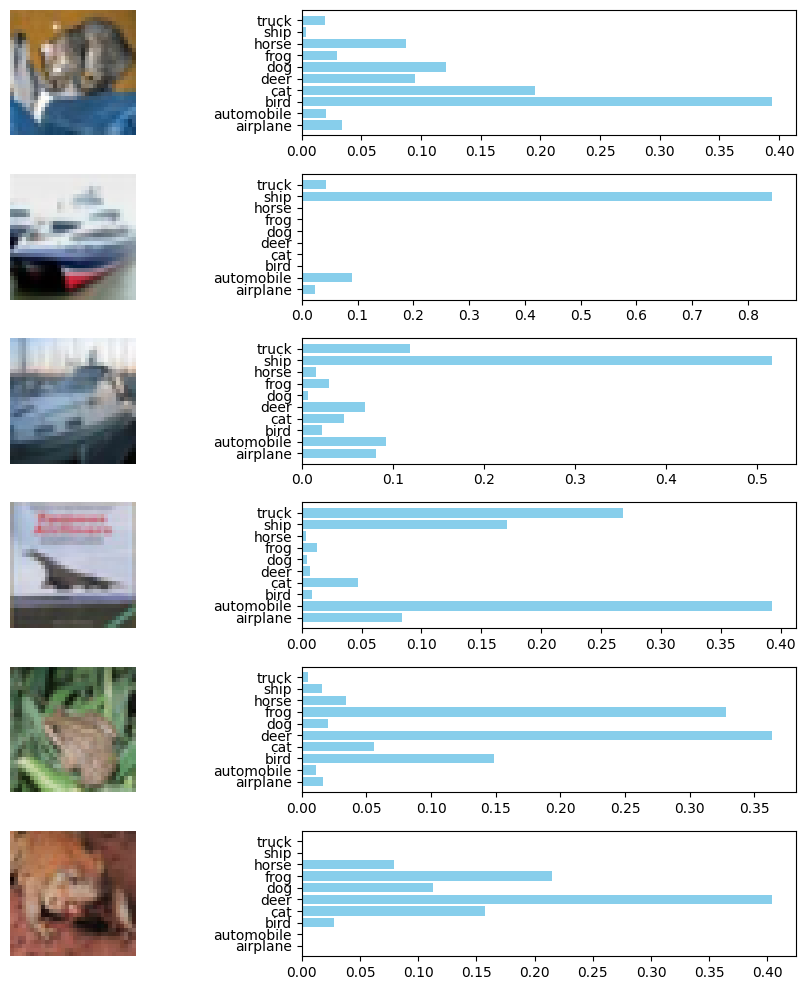

In [84]:
################## TODO BLOCK
plot_proba_from_model(model_pt, test_dataset, range(6),device)
################## END TODO BLOCK